# What is the relationship between Zoning and Transit Use per US Census

Steps for Analysis
1. Load the affected areas (h/t Sasha) 
2. Load the zoning areas 
3. Load the Census Tracts 
4. Join DataFrame with Census Tracts, Affected Areas and Parcels 
5. Load Census Data, normalize 
6. Compute "ChangeScore"
7. Determine Relationship 

## Source Data
* [US Census Blocks, CA](https://www.census.gov/geo/maps-data/data/cbf/cbf_tracts.html) 

In [1]:
import pandas as pd
import geopandas as gpd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
## Affected Areas
# Parse the shapes from Sasha's map

import json
import shapely.geometry

# convert the shapes used by the webapp to shapely shapes
def webappToShape (shp):
    return shapely.geometry.shape({
        'type': 'MultiPolygon',
        'coordinates': [[[[ll['lng'], ll['lat']] for ll in poly]] for poly in shp]
    })

# Load SB 827 data
with open('../../upzone-california/data/low_rise_shape.json') as lowRiseFd:
    lowRise = webappToShape(json.load(lowRiseFd))

with open('../../upzone-california/data/high_rise_shape.json') as highRiseFd:
    highRise = webappToShape(json.load(highRiseFd)).buffer(1e-8)

affectedArea = lowRise.union(highRise)


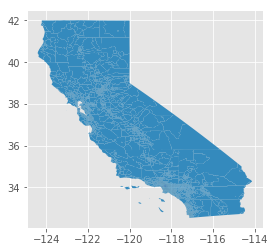

In [3]:
## Census Tracs 
census_tracts = gpd.read_file('../data/cb_2016_06_tract_500k/cb_2016_06_tract_500k.shp')
census_tracts.plot()

In [24]:
## Zoning Affected 
enriched = gpd.read_file('../data/enriched.geo.json')
enriched.head(5)

,nh,dh,ct,zn,zp,zd,zh,geometry
0,45.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9094202832327 37.3716361135314,..."
1,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9173055362167 37.37697169680511...
2,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,"POLYGON ((-121.9167140425162 37.3764636035302,..."
3,55.0,0.0,1400000US06085505006,None,NaN,NaN,NaN,POLYGON ((-121.9178789922728 37.37724185949239...
4,NaN,NaN,1400000US06085504314,None,NaN,NaN,NaN,"POLYGON ((-121.8518587036548 37.4056524988482,..."


* zn: zone name
* zh: zone height limit
* zp: zone mininum parking per unit
* zd: zone maximum density per acre
* nh: minimum height maximum under SB827
* dh: delta height under SB827

In [169]:
from util import get_dataframe, get_data

In [170]:
enriched['ct_strip'] = enriched['ct'].str[9:]
census_prefix = '14000US'
enriched['geoid'] = enriched['ct_strip'].apply(lambda x: census_prefix + str(x))
del(enriched['ct_strip'])

In [185]:
lookup_list = enriched['geoid'].unique()
i = 0
raw_data = []
while i < 2605:
    print("Start Index: ", i)
    step_size = 100
    try:
        raw_data.append(get_dataframe(tables=['B08301'], geoids = lookup_list[i:i+step_size],col_names=True))
    except KeyError:
        pass
    i += step_size
affected_tracts_with_data = pd.concat(raw_data)
affected_tracts_with_data.head()

Start Index:  0
Start Index:  100
Start Index:  200
Start Index:  300
Start Index:  400
Start Index:  500
Start Index:  600
Start Index:  700
Start Index:  800
Start Index:  900
Start Index:  1000
Start Index:  1100
Start Index:  1200
Start Index:  1300
Start Index:  1400
Start Index:  1500
Start Index:  1600
Start Index:  1700
Start Index:  1800
Start Index:  1900
Start Index:  2000
Start Index:  2100
Start Index:  2200
Start Index:  2300
Start Index:  2400
Start Index:  2500
Start Index:  2600


,Total:,"Car, truck, or van:",Drove alone,Carpooled:,In 2-person carpool,In 3-person carpool,In 4-person carpool,In 5- or 6-person carpool,In 7-or-more-person carpool,Public transportation (excluding taxicab):,...,Streetcar or trolley car (carro publico in Puerto Rico),Subway or elevated,Railroad,Ferryboat,Taxicab,Motorcycle,Bicycle,Walked,Other means,Worked at home
14000US06037106010,1473.0,1384.0,1191.0,193.0,147.0,46.0,0.0,0.0,0.0,13.0,...,0.0,0.0,0.0,0.0,0.0,23.0,0.0,35.0,11.0,7.0
14000US06037106020,2857.0,2614.0,2365.0,249.0,170.0,47.0,32.0,0.0,0.0,183.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,13.0
14000US06037106111,2214.0,2020.0,1681.0,339.0,243.0,80.0,8.0,0.0,8.0,50.0,...,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,127.0
14000US06037106406,2610.0,2385.0,1732.0,653.0,405.0,73.0,0.0,175.0,0.0,66.0,...,0.0,0.0,51.0,0.0,0.0,16.0,0.0,0.0,0.0,143.0
14000US06037106510,2373.0,2134.0,1852.0,282.0,165.0,43.0,22.0,0.0,52.0,116.0,...,0.0,5.0,67.0,0.0,0.0,47.0,0.0,7.0,0.0,69.0


### Compute `Changescore` 

Changescore is made up of three variables - height change, resident density change and parking change average for normalized by area in a census tract. 


In [189]:
## Compute `Changescore` 

census_parcel_groups = enriched.groupby(['geoid'])

from sklearn import preprocessing

census_parcel_groups_mean = census_parcel_groups.mean().dropna()
min_max_scaler = preprocessing.MinMaxScaler()
census_parcel_groups_mean['dh_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['dh'].reshape(-1, 1))
census_parcel_groups_mean['zd_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zd'].reshape(-1, 1))
census_parcel_groups_mean['zp_normalized'] = min_max_scaler.fit_transform(census_parcel_groups_mean['zp'].reshape(-1, 1))

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


In [190]:
changescores = census_parcel_groups_mean['dh_normalized'] + \
               census_parcel_groups_mean['zd_normalized'] + \
               census_parcel_groups_mean['zp_normalized']

In [191]:
change_df = pd.DataFrame({"changescores": changescores, 
                          "normalized": min_max_scaler.fit_transform(changescores.values.reshape(-1,1)).tolist()})
change_df["normalized"] = change_df['normalized'].apply(lambda x: x[0])
change_df.describe()

,changescores,normalized
count,1.311000e+03,1311.000000
mean,1.044698e+00,0.626819
std,2.501151e-01,0.150069
min,1.160237e-07,0.000000
25%,9.345263e-01,0.560716
50%,1.042369e+00,0.625421
75%,1.142492e+00,0.685495
max,1.666667e+00,1.000000


In [212]:
## Join to the affect tracts 
df = affected_tracts_with_data.join(change_df, how='inner')
## Didn't Drive Alone
df['not_alone'] = df.apply(lambda x: x['Total:'] - x['Drove alone'], axis=1)
df['not_alone_percent'] = df.apply(lambda x: x['not_alone'] / x['Total:'], axis=1)

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [213]:
df.columns[no]

Index(['Total:', 'Car, truck, or van:', 'Drove alone', 'Carpooled:',
       'In 2-person carpool', 'In 3-person carpool', 'In 4-person carpool',
       'In 5- or 6-person carpool', 'In 7-or-more-person carpool',
       'Public transportation (excluding taxicab):', 'Bus or trolley bus',
       'Streetcar or trolley car (carro publico in Puerto Rico)',
       'Subway or elevated', 'Railroad', 'Ferryboat', 'Taxicab', 'Motorcycle',
       'Bicycle', 'Walked', 'Other means', 'Worked at home', 'changescores',
       'normalized', 'not_alone', 'not_alone_percent'],
      dtype='object')

In [216]:
import seaborn as sns
sns.set()
df[['not_alone_percent','normalized']].head()

,not_alone_percent,normalized
14000US06037106010,0.191446,0.474105
14000US06037106020,0.172209,0.568571
14000US06037106111,0.240741,0.401099
14000US06037106406,0.336398,0.635051
14000US06075010100,0.764569,0.646257


Text(0.5,1,'Relationship between SB 827 Change and not-single-occupancy vehicle communting')

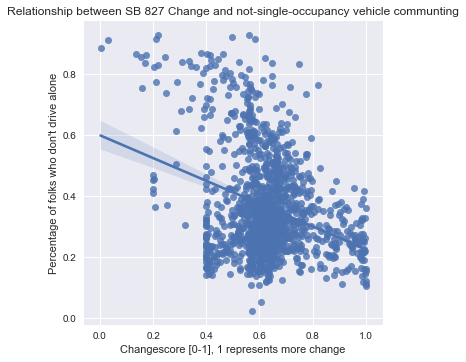

In [229]:
# Plot tip as a function of toal bill across days
g = sns.lmplot(x="normalized", y="not_alone_percent",
               truncate=True, size=5, data=df)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Changescore [0-1], 1 represents more change", "Percentage of folks who don't drive alone")

ax = plt.gca()
ax.set_title("Relationship between SB 827 Change and not-single-occupancy vehicle communting")

In [231]:
f = ax.get_figure()
f.savefig('proof.png')

/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/hunterowens/anaconda3/envs/sb827/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.